## Data Import and Preprocessing

### 1. a) Import Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf

from pandas import read_csv
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time

### Mount Google drive for using the dataset

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Colab Notebooks

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks


In [3]:
%ls

'DL Assignment 1.ipynb'   DL_Assignment2_Problem4.ipynb
'DL Assignment 2.ipynb'  'UCI HAR Dataset'/


#### 1. b. Check if GPU is available

In [4]:
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(False) # Start with XLA disabled.

# Check if GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2. Data Preprocessing

#### a. Load single file

In [5]:
# Create a function to load a single file as a numpy array
def load_single_file(filepath):
  df = pd.read_csv(filepath, header = None, delim_whitespace = True)
  return df.values

#### b. Load group

In [6]:
# Create a function to load a list of files and return as a 3d numpy array
def load_group(files, prefix=''):
	loaded = []
	for file in files:
		data = load_single_file(prefix + file)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded

#### c. Load dataset group

In [7]:
# Create a function to load a dataset group (e.g., train or test)
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all files as a single array

	files = []
	files += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt'] # total acceleration
	files += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt'] # body acceleration
	files += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']	# body gyroscope

	X = load_group(files, filepath)

	y = load_single_file(prefix + group + '/y_'+group+'.txt')

	return X, y

#### d. Load dataset

In [8]:
# Create a function to load the dataset. This function returns X and y elements of train and test data
def load_dataset(prefix = '/gdrive/My Drive/Colab Notebooks/UCI '):

	X_train, Y_train = load_dataset_group('train', prefix + 'HAR Dataset/') # Load training data
	print("Training data shape is: " + str(X_train.shape))

	X_test, Y_test = load_dataset_group('test', prefix + 'HAR Dataset/') # Load test data
	print("Test data shape is: " + str(X_test.shape))

	# zero-offset class values
	Y_train = Y_train - 1
	Y_test = Y_test - 1
	# one hot encode y
	Y_train = to_categorical(Y_train)
	Y_test = to_categorical(Y_test)

	return X_train, Y_train, X_test, Y_test

In [28]:
X_train, Y_train, X_test, Y_test = load_dataset()

Training data shape is: (7352, 128, 9)
Test data shape is: (2947, 128, 9)


### 3. Model Visualization

#### We have plotted line graphs for 2 observation for 'Walking Upstairs' and 'Walking Downstairs' for all 9 features of the dataset

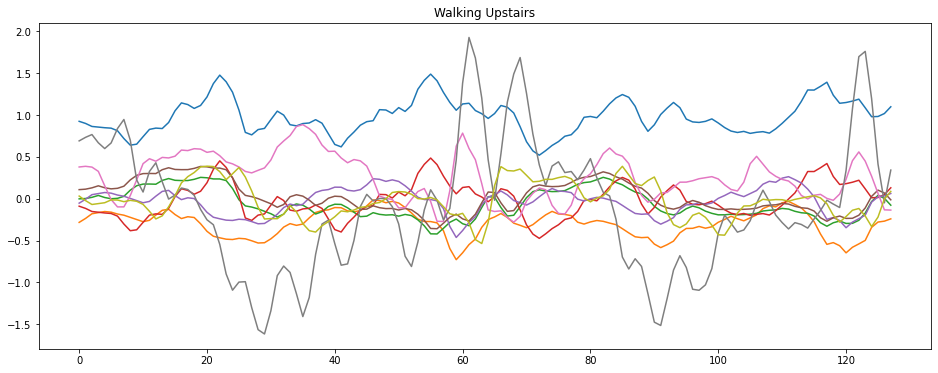

In [10]:
# features = ['total_acc_x', 'total_acc_y', 'total_acc_z', 'body_acc_x', 
#             'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 
#             'body_gyro_z']

plt.figure(figsize=(16,6))

for i in range(Y_train.shape[0]):
  if np.argmax(Y_train[i]) == 1: # The label for Walking Upstairs is 1
    for j in range(9): # this loop plots multiple lines for each feature (features mentioned above in list)
      sns.lineplot(x=range(128), y=np.transpose(X_train[i])[j])
    break

_ = plt.title('Walking Upstairs')

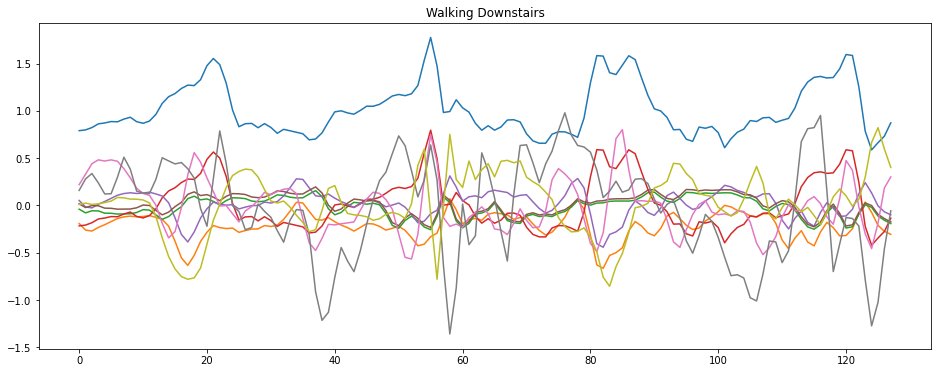

In [11]:
# features = ['total_acc_x', 'total_acc_y', 'total_acc_z', 'body_acc_x', 
#             'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 
#             'body_gyro_z']

plt.figure(figsize=(16,6))

for i in range(Y_train.shape[0]):
  if np.argmax(Y_train[i]) == 2: # The label for Walking Downstairs is 1
    for j in range(9): # this loop plots multiple lines for each feature (features mentioned above in list)
      sns.lineplot(x=range(128), y=np.transpose(X_train[i])[j])
    break

_ = plt.title('Walking Downstairs')

## Model 1: Develop an LSTM Network Model

### 1. Model Building

#### a. Sequential Model layers

#### b. Added dropout after input layer. Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel. It is a computationally cheap way to regularize a deep neural network.

#### c. Added 2 dense layers
#### d. Activations used in different layers
  * layer 1 - relu
  * layer 2 - softmax

#### e. Model summary printed

In [38]:
tf.keras.backend.clear_session()

In [39]:
# fit and evaluate a model
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
model = Sequential()
model.add(LSTM(120, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(120, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120)               62400     
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               14520     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 726       
Total params: 77,646
Trainable params: 77,646
Non-trainable params: 0
_________________________________________________________________
None


### 2. Model Compilation

#### a. Model is compiled with "categorical_crossentropy" as loss function.

#### b. The 'Adam' optimizer is used for compilation with learning rate as 0.001. We are using the Adam optimizer because it combines the benefit of AdaGrad and RMSProp. Adam is also an adaptive gradient descent algorithm, such that it maintains a learning rate per-parameter. The higher learning rates have tendency to overshoot and miss the minima whereas too small learning rate takes too many steps to reach the minima.

#### c. Accuracy is used as the metric for evaluation.

In [40]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### 3. Model Training
#### a. Model is trained with 15 epochs and batch_size of 64.

In [41]:
start_time = time.time()

history = model.fit(X_train, Y_train, epochs=15, batch_size=64, validation_split = 0.1, shuffle=False) # Fit model

print(f'Total training time is {round(time.time() - start_time)} seconds')

Epoch 1/15
104/104 [==============================] - 3s 13ms/step - loss: 1.5421 - accuracy: 0.3609 - val_loss: 1.2708 - val_accuracy: 0.5095
Epoch 2/15
104/104 [==============================] - 1s 9ms/step - loss: 1.2523 - accuracy: 0.4994 - val_loss: 1.0607 - val_accuracy: 0.6141
Epoch 3/15
104/104 [==============================] - 1s 9ms/step - loss: 0.9687 - accuracy: 0.6094 - val_loss: 0.9044 - val_accuracy: 0.5082
Epoch 4/15
104/104 [==============================] - 1s 9ms/step - loss: 0.8086 - accuracy: 0.6498 - val_loss: 0.6518 - val_accuracy: 0.7310
Epoch 5/15
104/104 [==============================] - 1s 9ms/step - loss: 0.6534 - accuracy: 0.7472 - val_loss: 0.9016 - val_accuracy: 0.6549
Epoch 6/15
104/104 [==============================] - 1s 9ms/step - loss: 0.7496 - accuracy: 0.6957 - val_loss: 0.4335 - val_accuracy: 0.8519
Epoch 7/15
104/104 [==============================] - 1s 9ms/step - loss: 0.5392 - accuracy: 0.8109 - val_loss: 0.3088 - val_accuracy: 0.9280
Epoch

### 3. b. The train and validation accuracies are printed along with execution time for each epoch.
* the total training time is printed in above cell

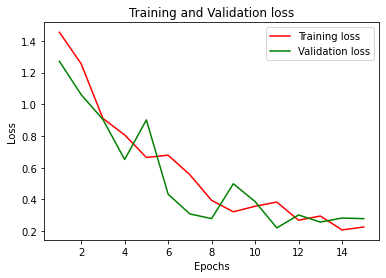

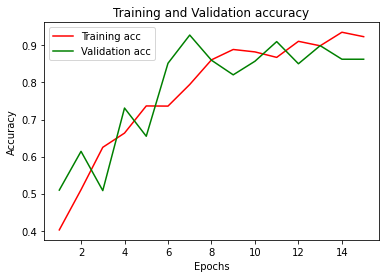

In [43]:
# plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plotting training and validation accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 4. Model Evaluation
#### a. Final training loss and accuracy for Train, Validation, and Test

In [44]:
# Printing the total training loss and accuracy

print('Final training loss \t', history.history['loss'][-1])
print('Final training accuracy ', history.history['accuracy'][-1])

Final training loss 	 0.22611266374588013
Final training accuracy  0.9236698746681213


In [45]:
# Printing the total validation loss and accuracy

print('Final Validation loss \t', history.history['val_loss'][-1])
print('Final Validation accuracy ', history.history['val_accuracy'][-1])

Final Validation loss 	 0.27898892760276794
Final Validation accuracy  0.86277174949646


In [46]:
testLoss, testAccuracy = model.evaluate(X_test, Y_test, batch_size=64) # evaluate model
print(f"Test Loss is {round(testLoss,4)}")
print(f"Test Accuracy is {round(testAccuracy*100,2)}% ")

47/47 [==============================] - 0s 7ms/step - loss: 0.2958 - accuracy: 0.9002
Test Loss is 0.2958
Test Accuracy is 90.02% 


#### b. Classification Report and Confusion Matrix
Based on F1-Scores, class 5 is the best performing while classes 3 and 4 are the worst performing class. From the loss and accuracy graphs we can observe that the model is performing equally well with training and validation data. The classification report shows that the overall performance of the model is decent.

In [47]:
Y_pred = model.predict_classes(X_test)
Y_true = np.argmax(Y_test, axis=1)
print("Classification Report")
print(classification_report(Y_pred, Y_true))
print("-"*100)
print("Confusion Matrix")
print(confusion_matrix(Y_pred, Y_true))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Classification Report
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       514
           1       0.86      0.95      0.90       428
           2       0.99      0.92      0.96       453
           3       0.89      0.76      0.82       571
           4       0.73      0.88      0.80       440
           5       1.00      0.99      1.00       541

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.91      0.90      0.90      2947

----------------------------------------------------------------------------------------------------
Confusion Matrix
[[471  36   2   1   4   0]
 [ 16 406   1   0   5   0]
 [  8  27 417   1   0   0]
 [  0   0   0 435 136   0]
 [  0   0   0  53 387   0]
 [  1   2   0   1   0 537]]


## Model 2: Develop a CNN-LSTM Network Model

### 1. Model Building

#### a. Sequential Model layers with 2 CNN-LSTM layers with 64 filters and 128 LSTM units

#### b. Added MaxPooling1D layer

#### c. Added 2 dense layers

#### d. Activations used in different layers
  * layer 1 - relu
  * layer 2 - relu
  * layer 3 - relu
  * layer 4 - softmax

#### e. Model summary printed

In [42]:
tf.keras.backend.clear_session()

In [20]:
# Load dataset again for model 2
X_train, Y_train, X_test, Y_test = load_dataset()

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(120))
model.add(Dense(120, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

print(model.summary())

Training data shape is: (7352, 128, 9)
Test data shape is: (2947, 128, 9)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 896)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               488160    
_________________________________________________________________
dense_2 (Dense)              (None, 120)               14520     
______________________________________________

### 2. Model Compilation

#### a. Model is compiled with "categorical_crossentropy" as loss function.

#### b. We are using SGD (Stochastic Gradient Descent) with learning rate 0.05 for model compilation. We experimented with various learning rates and 0.05 seems to be giving the best accuracy

#### c. Accuracy is used as the metric for evaluation.

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.05)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### 3. Model Training
#### a. Model is trained with 15 epochs and batch_size of 64.

In [22]:
start_time = time.time()

history = model.fit(X_train, Y_train, epochs=15, batch_size=64, validation_split = 0.1, shuffle=True) # Fit model

print(f'Total training time is {round(time.time() - start_time)} seconds')

Epoch 1/15
104/104 [==============================] - 3s 9ms/step - loss: 1.5785 - accuracy: 0.4113 - val_loss: 0.9111 - val_accuracy: 0.6101
Epoch 2/15
104/104 [==============================] - 0s 5ms/step - loss: 0.7340 - accuracy: 0.6992 - val_loss: 0.8819 - val_accuracy: 0.5435
Epoch 3/15
104/104 [==============================] - 0s 4ms/step - loss: 0.5817 - accuracy: 0.7440 - val_loss: 0.4273 - val_accuracy: 0.8410
Epoch 4/15
104/104 [==============================] - 0s 4ms/step - loss: 0.4797 - accuracy: 0.8018 - val_loss: 0.3362 - val_accuracy: 0.8750
Epoch 5/15
104/104 [==============================] - 0s 4ms/step - loss: 0.4080 - accuracy: 0.8424 - val_loss: 0.2996 - val_accuracy: 0.8736
Epoch 6/15
104/104 [==============================] - 0s 5ms/step - loss: 0.3432 - accuracy: 0.8663 - val_loss: 0.3935 - val_accuracy: 0.7962
Epoch 7/15
104/104 [==============================] - 0s 4ms/step - loss: 0.2817 - accuracy: 0.9002 - val_loss: 0.2628 - val_accuracy: 0.8696
Epoch 

### 3. b. The train and validation accuracies are printed along with execution time for each epoch.
* the total training time is printed in above cell

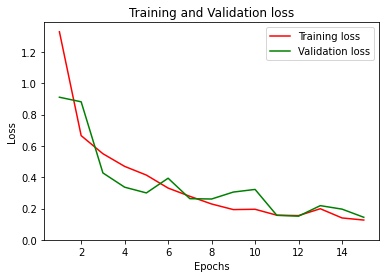

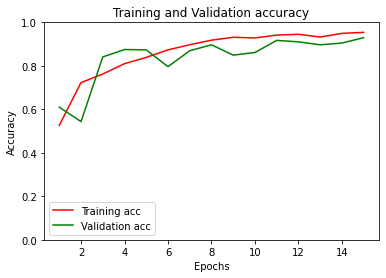

In [23]:
# plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(bottom = 0)
plt.legend()
plt.show()

# plotting training and validation accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.legend()
plt.show()

### 4. Model Evaluation
#### a. Final training loss and accuracy for Train, Validation, and Test

In [24]:
# Printing the total training loss and accuracy

print('Final training loss \t', history.history['loss'][-1])
print('Final training accuracy ', history.history['accuracy'][-1])

Final training loss 	 0.12613900005817413
Final training accuracy  0.9540507793426514


In [25]:
# Printing the total validation loss and accuracy

print('Final Validation loss \t', history.history['val_loss'][-1])
print('Final Validation accuracy ', history.history['val_accuracy'][-1])

Final Validation loss 	 0.14387430250644684
Final Validation accuracy  0.929347813129425


In [26]:
# Printing the total test loss and accuracy

testLoss, testAccuracy = model.evaluate(X_test, Y_test, batch_size=64) # evaluate model
print(f"Test Loss is {round(testLoss,4)}")
print(f"Test Accuracy is {round(testAccuracy*100,2)}% ")

47/47 [==============================] - 0s 3ms/step - loss: 0.3971 - accuracy: 0.8819
Test Loss is 0.3971
Test Accuracy is 88.19% 


#### b. Classification Report and Confusion Matrix
Based on F1-Scores, classes 0 and 5 are the best performing while classes 3 and 4 are the worst performing class. From the loss and accuracy graphs we can observe that the model is performing equally well with training and validation data. The classification report shows that the overall performance of the model is decent.

In [27]:
Y_pred = model.predict_classes(X_test)
Y_true = np.argmax(Y_test, axis=1)
print("Classification Report")
print(classification_report(Y_pred, Y_true))
print("-"*100)
print("Confusion Matrix")
print(confusion_matrix(Y_pred, Y_true))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       493
           1       0.91      0.86      0.89       496
           2       0.94      0.86      0.90       457
           3       0.76      0.82      0.79       453
           4       0.83      0.82      0.83       538
           5       0.95      1.00      0.97       510

    accuracy                           0.88      2947
   macro avg       0.88      0.88      0.88      2947
weighted avg       0.88      0.88      0.88      2947

----------------------------------------------------------------------------------------------------
Confusion Matrix
[[455  11  24   0   3   0]
 [  9 428   3  24   5  27]
 [ 32  32 393   0   0   0]
 [  0   0   0 371  82   0]
 [  0   0   0  96 442   0]
 [  0   0   0   0   0 510]]
